In [1]:
# Make sure you are using the right TensorFlow Version
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
!pip install tensorflow==2.14.1
!pip install -q tensorflow-model-optimization

#IMPORTANT!
#TFMO was tested against tensorflow 2.14.1 https://github.com/tensorflow/model-optimization/blob/master/RELEASE.md

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully

# Import packages

In [6]:
import numpy as np
import tensorflow as tf
# Keras is TensorFlow's high-level API for deep learning
import matplotlib.pyplot as plt
import math
import tensorflow_model_optimization as tfmot

In [7]:
print("TensorFlow Version:", tf.__version__)
print("TF Model Optimization Version:", tfmot.__version__)

TensorFlow Version: 2.14.1
TF Model Optimization Version: 0.8.0


# Generate data

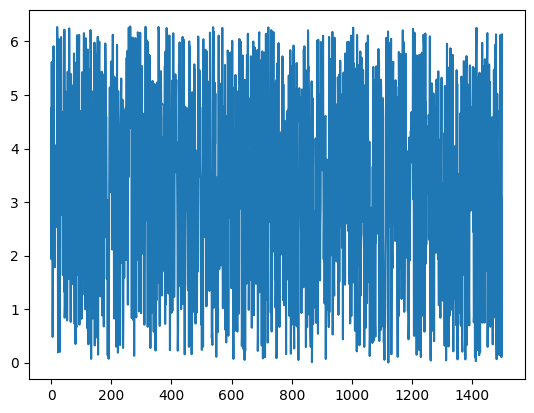

In [8]:
# Number of sample datapoints
SAMPLES = 1500

# Set a "seed" value, so we get the same random numbers each time we run this
# notebook for reproducible results. Any number can be used here.
np.random.seed(786)
tf.random.set_seed(786)

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# Let's visualize x_values to see if the x_values are random or
# concentrated in one area
plt.plot(x_values)
plt.show()

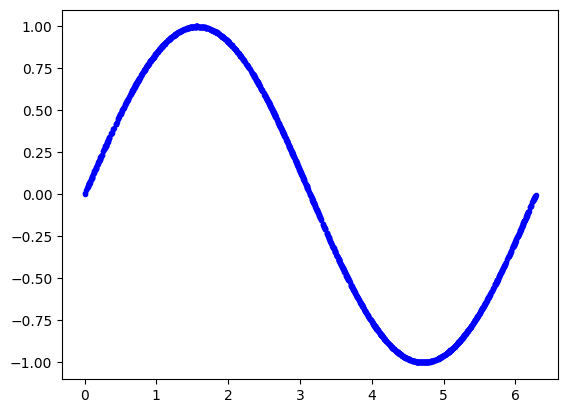

In [9]:
# You can also shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

# Add noise
Real world sensor data is rarely this smooth. For example, if you would have collect an accelerometer data for training it would have been noisy. To reflect real-world situation let's add some noise to the output.

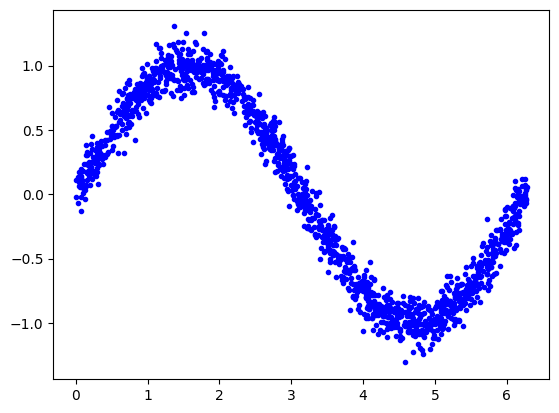

In [10]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

We now have a noisy dataset that approximates real world data.

# Split the Data
It is a common practice to split the data into 60-20-20 for training and testing. The data is split as follows:
  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20%

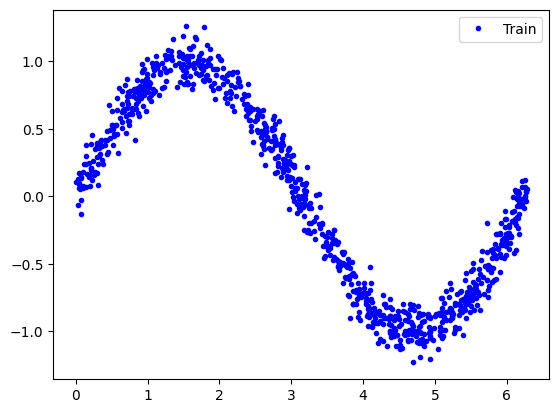

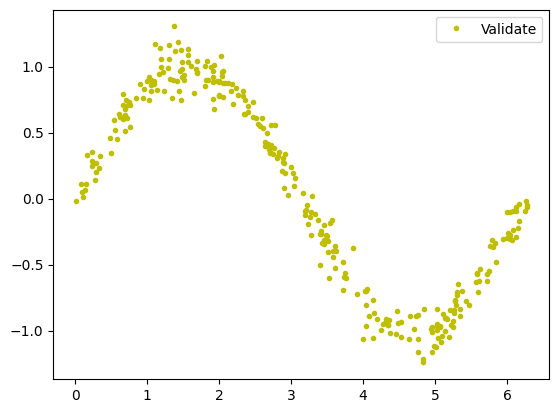

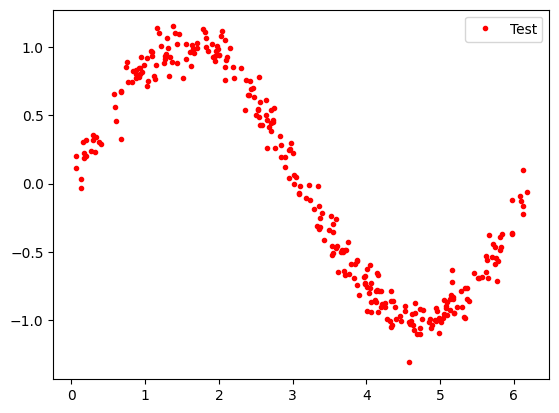

In [11]:
# We'll use 60% of our data for training and 20% for validation. The remaining 20%
# will be used for testing. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition.
# We have to make sure that each set, train, validation and test, has the full
# range of x values, 0 to 2pi
plt.plot(x_train, y_train, 'b.', label="Train")
plt.legend()
plt.show()

plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

plt.plot(x_test, y_test, 'r.', label="Test")
plt.legend()

# Design the model
The model is going to predict a numeric value based on a numeric input. This type of problem is known as regression. We are going to solve this using neural network.

In neural network you have neurons (think of it as a node in a [mesh network](https://en.wikipedia.org/wiki/Mesh_networking)). Each of these neurons has weight and bias value. During training, these values are changed, by a _**activation function**_, that you will choose, to match its prediction with the actual output. A _**loss function**_ will be used to see how far the predictions are from the actual value and the training process will try to minimize this value.

You can have any numbers of layers of neurons. But the more neurons leads to more complexity, and hence will also increase the size of the model. We will be using two layers of 16 neurons (i.e. 32 neurons), with one input layer and one output layer.



In [12]:
# We'll use Keras to create a simple model architecture
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The second layer of 16 neurons. Note input connected to the first layer.
# As this is a sequential model, all the first layer neuron will be connected
# to this second layer.
model.add(tf.keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model.add(tf.keras.layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
During training, model will predict the output of a corrsponding input `x` and will check how far it is from the actual value. then it will adjust the neurons' weights and biases to match the actual output.

Epoch: Training runs this process on the full dataset multiple times, and each full run-through is known as an epoch and we can set this parameter. Don't use high number of epochs. Otherwise the model will overfit their training data.

Batch Size: During each epoch, you can adjust the weights and biases after each input. Or you can update those values in batches. For example, use 16 samples, aggregate their correctness results and then update weights and biases based on that. Choosing 1 as batch size will take forever to train, choosing the whole data as batch size will result in less accurate model. Its a trial and error situation. Thumb of rule is start with a batch size of 16 or 32 and increase from their to see what works best for you.

In [14]:
training_info = model.fit(x_train, y_train, epochs=350, batch_size=64, validation_data=(x_validate, y_validate))

Epoch 1/350
15/15 [==============================] - 1s 12ms/step - loss: 0.5174 - mae: 0.5971 - val_loss: 0.4477 - val_mae: 0.5768
Epoch 2/350
15/15 [==============================] - 0s 4ms/step - loss: 0.3726 - mae: 0.5329 - val_loss: 0.4151 - val_mae: 0.5625
Epoch 3/350
15/15 [==============================] - 0s 4ms/step - loss: 0.3361 - mae: 0.5044 - val_loss: 0.3796 - val_mae: 0.5355
Epoch 4/350
15/15 [==============================] - 0s 4ms/step - loss: 0.3068 - mae: 0.4768 - val_loss: 0.3537 - val_mae: 0.5152
Epoch 5/350
15/15 [==============================] - 0s 3ms/step - loss: 0.2839 - mae: 0.4600 - val_loss: 0.3213 - val_mae: 0.4945
Epoch 6/350
15/15 [==============================] - 0s 4ms/step - loss: 0.2612 - mae: 0.4446 - val_loss: 0.2963 - val_mae: 0.4759
Epoch 7/350
15/15 [==============================] - 0s 4ms/step - loss: 0.2437 - mae: 0.4310 - val_loss: 0.2753 - val_mae: 0.4595
Epoch 8/350
15/15 [==============================] - 0s 3ms/step - loss: 0.2279 - 

# Plot Metrics
During each training epoch, the model prints out its loss and mean absolute error for training and validation as you can see in the output above (note that your exact numbers may differ):

```
Epoch 350/350
15/15 [==============================] - 0s 4ms/sample - loss: 0.0105 - mae: 0.0809 - val_loss: 0.0108 - val_mae: 0.0803
```

Let's see that on a graph how model's performance changed over time:

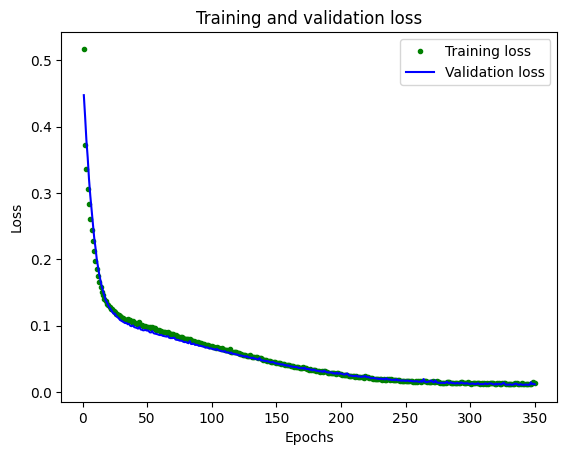

In [15]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = training_info.history['loss']
validation_loss = training_info.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The loss rapidly decresed at the beginnig before flattening out at the end. To make flatter part more readable let's skip first 50 epochs:

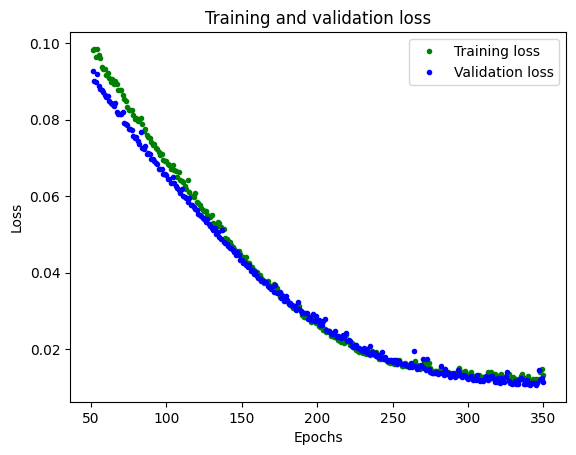

In [16]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], validation_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the plot, we can see that loss continues to reduce until around 200 epochs, at which point it is mostly stable.

We can also see that the lowest loss value is around 0.0108. This means that our network's predictions are off by an average of ~1%. Which is really good.

Let's plot the mean absolute error, which is another way of measuring how far the network's predictions are from the actual numbers:

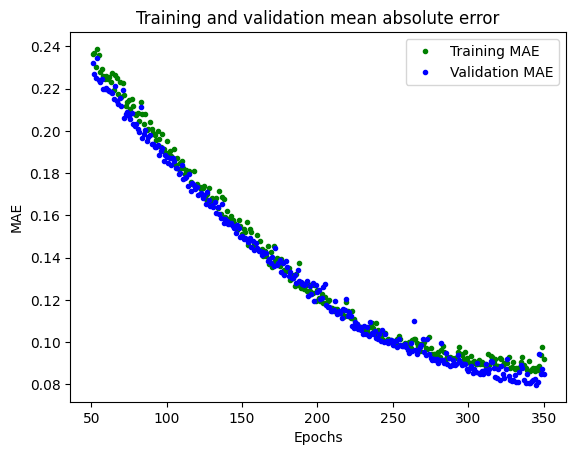

In [17]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = training_info.history['mae']
validation_mae = training_info.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], validation_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

We can see that metrics are better for validation than training and that means the network is not overfitting. This means our network seems to be performing well! To confirm, let's check its predictions against the **Test** dataset we set aside earlier:

10/10 [==============================] - 0s 3ms/step


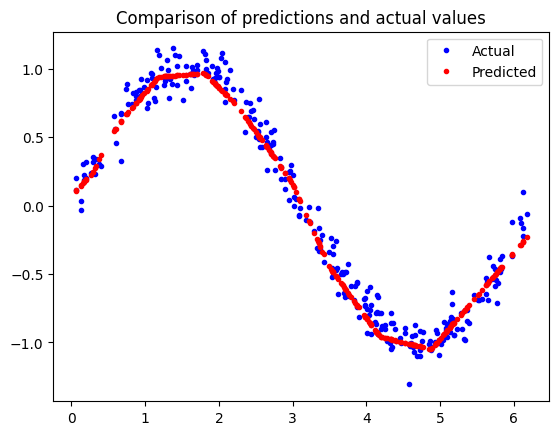

In [18]:
# Calculate and print the loss on our test dataset
loss = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
predictions = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

Looks really great! The model isn't perfect; its predictions don't form a smooth sine curve. If we wanted to go further, we could try further increasing the capacity of the model.

However, an important part of machine learning is knowing when to quit, and this model is good enough for our use case - which is to show a sine wave pattern on an LCD.

## Generate a TensorFlow Lite Model

We now have an acceptably accurate model. We'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert the model into a special, space-efficient format for use on memory-constrained devices.

In [19]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

In [20]:
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model to disk
#open("sinewave_model.tflite", "wb").write(tflite_model)

In [21]:
from pathlib import Path
model_path = Path("saved_model/1/saved_model.pb")
size_bytes = model_path.stat().st_size
print(f"Tamaño de saved_model.pb: {size_bytes} bytes")

Tamaño de saved_model.pb: 89745 bytes


In [22]:
import pathlib
tflite_model_file = pathlib.Path('model.tflite')
print("Tamaño del modelo convertido:",tflite_model_file.write_bytes(tflite_model), "bytes")

Tamaño del modelo convertido: 3168 bytes


# Quantization Aware Training

In [13]:
q_aware_model = tfmot.quantization.keras.quantize_model(model)

q_aware_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 1)                 3         
 yer)                                                            
                                                                 
 quant_dense (QuantizeWrapp  (None, 16)                37        
 erV2)                                                           
                                                                 
 quant_dense_1 (QuantizeWra  (None, 16)                277       
 pperV2)                                                         
                                                                 
 quant_dense_2 (QuantizeWra  (None, 1)                 22        
 pperV2)                                                         
                                                                 
Total params: 339 (1.32 KB)
Trainable params: 321 (1.25 

# Train

In [23]:
training_info = q_aware_model.fit(x_train, y_train, epochs=350, batch_size=64, validation_data=(x_validate, y_validate))

Epoch 1/350
15/15 [==============================] - 1s 14ms/step - loss: 0.5152 - mae: 0.5957 - val_loss: 0.4505 - val_mae: 0.5786
Epoch 2/350
15/15 [==============================] - 0s 5ms/step - loss: 0.3683 - mae: 0.5294 - val_loss: 0.4124 - val_mae: 0.5611
Epoch 3/350
15/15 [==============================] - 0s 5ms/step - loss: 0.3342 - mae: 0.5027 - val_loss: 0.3801 - val_mae: 0.5369
Epoch 4/350
15/15 [==============================] - 0s 3ms/step - loss: 0.3037 - mae: 0.4752 - val_loss: 0.3542 - val_mae: 0.5168
Epoch 5/350
15/15 [==============================] - 0s 5ms/step - loss: 0.2837 - mae: 0.4576 - val_loss: 0.3230 - val_mae: 0.4917
Epoch 6/350
15/15 [==============================] - 0s 4ms/step - loss: 0.2594 - mae: 0.4419 - val_loss: 0.2896 - val_mae: 0.4705
Epoch 7/350
15/15 [==============================] - 0s 5ms/step - loss: 0.2425 - mae: 0.4298 - val_loss: 0.2725 - val_mae: 0.4577
Epoch 8/350
15/15 [==============================] - 0s 4ms/step - loss: 0.2258 - 

# Evaluacion de la precision y tamaño del modelo base, sin QAT y con QAT




In [45]:
from sklearn.metrics import mean_absolute_error
import os

# ---- MAE del modelo base (Keras) ----
y_pred_base = model.predict(x_test)
mae_base = mean_absolute_error(y_test, y_pred_base)
print("Modelo base - MAE:", mae_base)

#guardar
model.save('model_original.h5')

# ---- MAE del modelo TFLite sin QAT ----
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

y_pred_tflite = []
for i in range(len(x_test)):
    input_data = np.array([[x_test[i]]], dtype=input_details[0]['dtype'])
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    y_pred_tflite.append(output[0][0])

mae_tflite = mean_absolute_error(y_test, y_pred_tflite)
print("TFLite sin QAT - MAE:", mae_tflite)

#guardar
with open('model_sin_qat.tflite', 'wb') as f:
    f.write(tflite_model)

# ---- MAE del modelo TFLite con QAT ----
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Fuerza uso de solo operaciones cuantizadas
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Fuerza tipos de entrada/salida en int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Para que la cuantización sea completa, también necesitas un representative dataset:
def representative_dataset():
    for x in x_test[:100]:
        yield [np.array([[x]], dtype=np.float32)]

converter.representative_dataset = representative_dataset

tflite_model_qat = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model_qat)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

in_scale, in_zero = input_details[0]['quantization']
out_scale, out_zero = output_details[0]['quantization']

# Asegurar que x_test tenga la forma correcta (n_samples, 1)
x_test_input = np.expand_dims(x_test, axis=-1)

# Lista para almacenar predicciones
y_pred_qat = []

# Pasar cada muestra por el modelo TFLite cuantizado
for i in range(len(x_test_input)):
    # Cuantizar la entrada a int8
    input_float = x_test_input[i]
    input_int8 = np.round(input_float / in_scale + in_zero).astype(np.int8)
    input_int8 = np.expand_dims(input_int8, axis=0)  # shape (1,1)
    # Inference
    interpreter.set_tensor(input_details[0]['index'], input_int8)
    interpreter.invoke()
    output_int8 = interpreter.get_tensor(output_details[0]['index'])[0][0]

    # Descuantizar la salida a float
    output_float = (output_int8 - out_zero) * out_scale
    y_pred_qat.append(output_float)

# Calcular MAE
mae_qat = mean_absolute_error(y_test, y_pred_qat)
print("TFLite con QAT (int8) - MAE:", mae_qat)

#guardar
with open('model_con_qat.tflite', 'wb') as f:
    f.write(tflite_model_qat)

#comparacion de tamaños
size_original = os.path.getsize('model_original.h5') / 1024
size_tflite = os.path.getsize('model_sin_qat.tflite') / 1024
size_qat = os.path.getsize('model_con_qat.tflite') / 1024

print(f"Tamaño del modelo original (Keras): {size_original:.2f} KB")
print(f"Tamaño del modelo TFLite sin QAT: {size_tflite:.2f} KB")
print(f"Tamaño del modelo TFLite con QAT: {size_qat:.2f} KB")


10/10 [==============================] - 0s 1ms/step
Modelo base - MAE: 0.08621445298677423


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TFLite sin QAT - MAE: 0.08621444441860654
TFLite con QAT (int8) - MAE: 0.0830688887955484
Tamaño del modelo original (Keras): 33.44 KB
Tamaño del modelo TFLite sin QAT: 3.09 KB
Tamaño del modelo TFLite con QAT: 2.86 KB


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [44]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_qat)
interpreter.allocate_tensors()
print(interpreter.get_input_details())
print(interpreter.get_output_details())


[{'name': 'serving_default_dense_input:0', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.024629225954413414, -128), 'quantization_parameters': {'scales': array([0.02462923], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 9, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.007899870164692402, -1), 'quantization_parameters': {'scales': array([0.00789987], dtype=float32), 'zero_points': array([-1], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


# Generate C files
Let's generate C source and header file of this model for microcontroller. TF Lite has a Python method to convert TF Lite model into C source and header files.

In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source

source_text, header_text = convert_bytes_to_c_source(tflite_model,
                                                     "sine_model",
                                                     include_path="sine_model.h")
with open('sine_model.h', 'w') as file:
    file.write(header_text)

with open('sine_model.cpp', 'w') as file:
    file.write(source_text)
